In [1]:
import torch
from torch import nn

from d2l import torch as d2l

In [2]:
torch.set_printoptions(profile="full")

In [3]:
n_train = 50
x_train , _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)   # 生成一个0到5间隔为0.1的一维张量
y_test = f(x_test)  # truth label
n_test = len(x_test)
print(n_test)

50


In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_test, y_hat], 'x', 'y', legend=['Truth', 'Predict'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

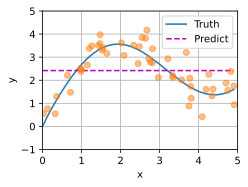

In [5]:
# 10.2.2 平均汇聚

y_hat = torch.repeat_interleave(y_train.mean(), n_test)

plot_kernel_reg(y_hat)

# 这里稍微解释一下avg aggr 平均汇聚的意思
意思就是，把 x_train 经过训练后 得到的 y_train，取平均值，然后复制n_test份，就是在这个注意力下，大家的值都一样了。
the meaning is that after training x_train to obtain y_train, we take the average value and then copy it n_test times, which means that everyone's values are the same, under this attention.

tensor([[-2.3473e-02, -1.2784e-01, -3.2392e-01, -3.6074e-01, -6.3861e-01,
         -7.1462e-01, -9.7659e-01, -9.8237e-01, -9.9849e-01, -1.1487e+00,
         -1.1966e+00, -1.2611e+00, -1.4295e+00, -1.4728e+00, -1.4767e+00,
         -1.5218e+00, -1.5461e+00, -1.6469e+00, -2.0234e+00, -2.0909e+00,
         -2.3374e+00, -2.4486e+00, -2.4814e+00, -2.5513e+00, -2.6400e+00,
         -2.6723e+00, -2.7196e+00, -2.7614e+00, -2.8172e+00, -2.8197e+00,
         -2.9697e+00, -3.2127e+00, -3.3377e+00, -3.3430e+00, -3.5598e+00,
         -3.6849e+00, -3.7541e+00, -3.7745e+00, -3.8016e+00, -3.8085e+00,
         -4.0926e+00, -4.1919e+00, -4.2625e+00, -4.3454e+00, -4.3706e+00,
         -4.7050e+00, -4.7502e+00, -4.8248e+00, -4.9031e+00, -4.9148e+00],
        [ 7.6527e-02, -2.7838e-02, -2.2392e-01, -2.6074e-01, -5.3861e-01,
         -6.1462e-01, -8.7659e-01, -8.8237e-01, -8.9849e-01, -1.0487e+00,
         -1.0966e+00, -1.1611e+00, -1.3295e+00, -1.3728e+00, -1.3767e+00,
         -1.4218e+00, -1.4461e+00, -1

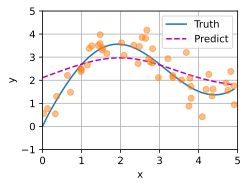

In [6]:
# 10.2.3 非参数注意力汇聚
t = x_test.repeat_interleave(n_train)
# print(x_test)
# print(t)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# print(f"x_train:{x_train.shape}")
# print(f"X_repeat:{X_repeat.shape}")
a = X_repeat - x_train
print(a)
# x_train_repeat = x_train.repeat_interleave(50).reshape((50, 50))  # 这样，x_train被横着扩展了
# 我们其实是希望x_train纵向拓展的，因此不能这么写，只能利用广播机制。
# print(x_train_repeat)
# print(a)
# print(X_repeat - x_train_repeat)
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim = 1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

# 解释一下这里为什么是X_repeat - x_train

由代码： X_repeat 为x_test先每个元素复制n_train份，再按照每n_train为一组进行分组。
因此X_repeat是对x_test的重复，所以这个注意力机制中，是观察x_test与x_train之间的距离，决定y_test的最终大小。

然后X_repeat - x_train的话，x_train广播，将第一行复制50份。作为50行。

这样，对于第一行来说，就是test_1 依次减去 train 的每个样本。其余行同理。

然后我们再对“行”进行Softmax，将一行全加起来，然后第一行第一列的元素除以这个值，第一行第二列也除以这个值，之后的效果是：
每行的所有元素加和为1.


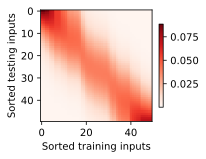

In [7]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# 带参数的注意力汇聚
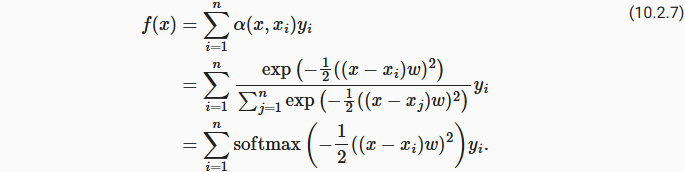

通过这个核函数，可以发现就是在Softmax中加了个w。


In [8]:
# 带参数的注意力汇聚
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [9]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [10]:
class NWKernelRegression(nn.Module):
    def __init__(self,**kwargs) -> None:
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    
    def forward(self, queries: torch.tensor, keys: torch.tensor, values: torch.tensor):
        """ Args:
        queries: 查询，一般是x_train, 这里的输入是x_train, 形状为[batch_size, n_train]
        keys: 键， 一般是x_test
        values: 是返回的values， 要Softmax
        """
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w) ** 2 / 2 , dim=1)   # 在行上进行Softmax
        t1 = self.attention_weights.unsqueeze(1)
        print(f't1.shape:{t1.shape}')
        print(f'values.shape:{values.shape}')
        print(f'values.unsqueeze(1).shape:{values.unsqueeze(-1).shape}')
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)
    

In [15]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
print(f'X_tile:{X_tile}')
print(f'Y_tile:{Y_tile}')
print(f'keys:{keys}')
print(f'values:{values}')

X_tile:tensor([[0.0235, 0.1278, 0.3239, 0.3607, 0.6386, 0.7146, 0.9766, 0.9824, 0.9985,
         1.1487, 1.1966, 1.2611, 1.4295, 1.4728, 1.4767, 1.5218, 1.5461, 1.6469,
         2.0234, 2.0909, 2.3374, 2.4486, 2.4814, 2.5513, 2.6400, 2.6723, 2.7196,
         2.7614, 2.8172, 2.8197, 2.9697, 3.2127, 3.3377, 3.3430, 3.5598, 3.6849,
         3.7541, 3.7745, 3.8016, 3.8085, 4.0926, 4.1919, 4.2625, 4.3454, 4.3706,
         4.7050, 4.7502, 4.8248, 4.9031, 4.9148],
        [0.0235, 0.1278, 0.3239, 0.3607, 0.6386, 0.7146, 0.9766, 0.9824, 0.9985,
         1.1487, 1.1966, 1.2611, 1.4295, 1.4728, 1.4767, 1.5218, 1.5461, 1.6469,
         2.0234, 2.0909, 2.3374, 2.4486, 2.4814, 2.5513, 2.6400, 2.6723, 2.7196,
         2.7614, 2.8172, 2.8197, 2.9697, 3.2127, 3.3377, 3.3430, 3.5598, 3.6849,
         3.7541, 3.7745, 3.8016, 3.8085, 4.0926, 4.1919, 4.2625, 4.3454, 4.3706,
         4.7050, 4.7502, 4.8248, 4.9031, 4.9148],
        [0.0235, 0.1278, 0.3239, 0.3607, 0.6386, 0.7146, 0.9766, 0.9824, 0.9985,
  

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
# animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net.forward(x_train, keys, values), y_train)
    # 从这里我们可以发现，在训练时候，将x_train作为query，x_train也作为keys, y_train作为values。
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    # animator.add(epoch + 1, float(l.sum()))

t1.shape:torch.Size([50, 1, 49])
values.shape:torch.Size([50, 49])
values.unsqueeze(1).shape:torch.Size([50, 49, 1])
epoch 1, loss 39.519611
t1.shape:torch.Size([50, 1, 49])
values.shape:torch.Size([50, 49])
values.unsqueeze(1).shape:torch.Size([50, 49, 1])
epoch 2, loss 19.233269
t1.shape:torch.Size([50, 1, 49])
values.shape:torch.Size([50, 49])
values.unsqueeze(1).shape:torch.Size([50, 49, 1])
epoch 3, loss 19.217176
t1.shape:torch.Size([50, 1, 49])
values.shape:torch.Size([50, 49])
values.unsqueeze(1).shape:torch.Size([50, 49, 1])
epoch 4, loss 19.200893
t1.shape:torch.Size([50, 1, 49])
values.shape:torch.Size([50, 49])
values.unsqueeze(1).shape:torch.Size([50, 49, 1])
epoch 5, loss 19.184410


# 均方误差 MSELoss与 reduction='none'
均方误差测量了模型的预测值与真实标签之间的平方差的均值。这有助于衡量模型的预测误差的大小。
## 均方误差
均方误差（Mean Squared Error，MSE）是一种常用于回归问题的损失函数，用于度量模型的预测值与真实标签之间的差异的平方的均值。MSE通常用于评估模型在连续数值预测任务中的性能，例如房价预测、股票价格预测等。

MSE 的数学定义如下：

对于单个样本 $(x, y)$，其中 $x$ 是模型的输入特征，$y$ 是真实的目标值，$y'$ 是模型的预测值，MSE 定义为：
$$
MSE(x, y) = \frac{1}{n} \sum_{i=1}^{n} (y'_i - y_i)^2
$$
其中：
$n$ 是样本的数量。
$y'_i$ 是模型对第 $i$ 个样本的预测值。
$y_i$ 是第 $i$ 个样本的真实目标值。

## reduction='none'
reduction='none'：这里指定了损失函数的参数 reduction 为 'none'。reduction 参数用于控制损失的降维方式。在这里，设置为 'none' 表示不进行降维操作。也就是说，对于每个样本，损失函数将计算该样本的均方误差，而不对这些损失进行平均或求和。这种设置在训练循环中可能很有用，因为它允许你查看每个样本的损失，而不是对它们进行聚合。
**个人以为，不加这个，就类似于后续进行了l.sum()等操作。**



t1.shape:torch.Size([50, 1, 50])
values.shape:torch.Size([50, 50])
values.unsqueeze(1).shape:torch.Size([50, 50, 1])


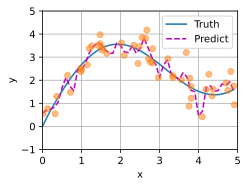

In [13]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

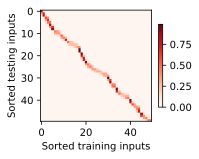

In [14]:
# 绘制注意力热力图
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0), 
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# unsqueeze 的用法
unsqueeze 是PyTorch中用于增加张量维度的方法之一。它在张量的指定位置插入一个新的维度，将原有的维度数增加1。并且新维度的大小始终为1。